In [1]:
# Jupyter notebooks have problems with imports from parent folder, so let's change the path
from jupyter_utils import change_path_to_parent
change_path_to_parent()

import matplotlib
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix

from first_order import AdgdAccel
from datasets import get_dataset
from loss_functions import LogSumExp
from second_order import Newton
from quasi_newton import Bfgs, Dfp, Lbfgs, Sr1
from utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rc('font', family='sans-serif') 
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'

The objective that we consider here is given as

$\qquad f(x) = \log\left(\sum_{i=1}^n \exp(a_i^\top x - b_i)\right) + \frac{\lambda}{2}\|x\|^2.$

Let us for simplicity discuss the case when $\lambda = 0$.

Note that if $f(x)=\log(\varphi_1(x)+\dotsb+\varphi_n(x))$, then $\nabla f(x)= \frac{1}{\varphi_1(x)+\dotsb+\varphi_n(x)}(\nabla\varphi_1(x)+\dotsb+\nabla \varphi_n(x)).$  
Therefore,

$\qquad\nabla f(x) = \sum_{i=1}^n\frac{\exp(a_i^\top x-b_i)}{\sum_{l=1}^n\exp(a_l^\top x-b_l)}a_i.$  

Denote $\pi_i(x)=\frac{\exp(a_i^\top x-b_i)}{\sum_{l=1}^n\exp(a_l^\top x-b_l)}$, then it is obvious that $\pi_i(x)\in (0, 1)$ for any $x$.  
Function $\pi(x)=(\pi_1(x),\dotsc, \pi_n(x))$ is called softmax. With its help, we can rewrite the gradient in a more convinient form as  
$\qquad \nabla f(x) = \sum_{i=1}^n \pi_i(x) a_i.$  
To get the second derivatives, we can use the rule $(\frac{g}{h})'=\frac{g'}{h}-\frac{h' g}{h^2}$, which gives  
$\qquad \nabla^2 f(x)=\sum_{i=1}^n \frac{\exp(a_i^\top x-b_i)}{\sum_{l=1}^n\exp(a_l^\top x-b_l)} a_i^\top a_i - \sum_{i=1}^n\sum_{j=1}^n\frac{\exp(a_i^\top x-b_i)\exp(a_j^\top x-b_j)}{(\sum_{l=1}^n\exp(a_l^\top x-b_l))^2}a_i a_j^\top= \sum_{i=1}^n \pi_i(x)a_ia_i^\top - \nabla f(x)(\nabla f(x))^\top.$  
Since $\pi_i(x)\le 1$ and $-\nabla f(x)(\nabla f(x))^\top \preccurlyeq 0$, we get  
$\qquad \nabla^2 f(x) \preccurlyeq \sum_{i=1}^n a_ia_i^\top = \mathbf{A}^\top \mathbf{A}$,  
where $\mathbf{A}=(a_1, \dotsc, a_n)^\top$. Thus, the gradient of $f$ is $L$-Lipschitz with $L$ given by

$\qquad L = \sigma_{\max}(\mathbf{A})^2\le \|\mathbf{A}\|^2_F.$

----------------------------
One might also combine the objective given above with a least-squares term and introduce a smoothing parameter $\rho$:

$\qquad f(x) = \rho\log\left(\sum_{i=1}^n \exp\left(\frac{a_i^\top x - b_i}{\rho}\right)\right) + \frac{1}{2}\|\mathbf{A}x\|^2 + \frac{\lambda}{2}\|x\|^2,$

The motivation for introducing $\rho$ is simply that it tightens the approximation of the maximum function, namely  
$\qquad \max\{\alpha_1,\dotsc, \alpha_n\} \le \rho\log\left(\sum_{i=1}^n\exp\left(\frac{\alpha_i}{\rho}\right)\right) \le \max\{\alpha_1,\dotsc, \alpha_n\} + \rho \log n,$

With smaller $\rho$, the approximation will be tighter but at the same time less numerically stable and harder to optimize. For the new objective, we have

$\qquad \pi_i(x)=\frac{\exp\left(\frac{a_i^\top x-b_i}{\rho}\right)}{\sum_{l=1}^n\exp\left(\frac{a_l^\top x-b_l}{\rho}\right)},$  
$\qquad\nabla f(x) = \sum_{i=1}^n\pi_i(x) a_i + \mathbf{A}^\top \mathbf{A}x + \lambda x,$  
$\qquad \nabla^2 f(x)=\frac{1}{\rho}\left(\sum_{i=1}^n \pi_i(x)a_ia_i^\top - \nabla f(x)(\nabla f(x))^\top\right) + \mathbf{A}^\top \mathbf{A} + \lambda \mathbf{I},$  
$\qquad L = \left(1+\frac{1}{\rho}\right)\sigma_{\max}(\mathbf{A})^2 + \lambda\le \left(1+\frac{1}{\rho}\right)\|\mathbf{A}\|^2_F + \lambda.$

## Standard log-sum-exp without extra terms

In [2]:
seed = 0
rng = np.random.default_rng(seed)

In [3]:
n, dim = 1000, 700
least_squares_term = False
max_smoothing = 1
l2 = 0
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2)
x0 = rng.normal(scale=0.5, size=dim)
it_max = 2000

## Define optimization algorithms

In [4]:
from first_order import Adgd, Gd, AdgdAccel, RestNest
from quasi_newton import Lbfgs, Shorr
def get_optimizers(loss):
    adgd = Adgd(loss=loss, label='AdGD')
    adgda = AdgdAccel(loss=loss, label='Accelerated AdGD')
    bfgs = Bfgs(loss=loss, label='BFGS')
    lbfgs = Lbfgs(loss=loss, label='Adaptive L-BFGS', adaptive_init=True, mem_size=16)
    rest = RestNest(loss=loss, label='Nesterov restarts')
    shorr = Shorr(loss=loss, label='Shor\'s R')
    sr1 = Sr1(loss=loss, label='SR1')
    optimizers = [bfgs, adgd, adgda, rest, shorr, lbfgs, sr1]
    return optimizers

In [5]:
markers = [',', 'o', '^', '*', 'd', 's', 'X', 'P', '.', 6, 7]

def run_and_plot(optimizers, plot_diverging=True):
    plt.figure(figsize=(9, 6))
    for opt in optimizers:
        print(f'Running optimizer: {opt.label}')
        opt.run(x0=x0, it_max=it_max)
        opt.compute_loss_of_iterates()
    for opt, marker in zip(optimizers, markers):
        nonan_min = np.nanmin(opt.trace.loss_vals[20:])
        did_not_converge = nonan_min > opt.trace.loss_vals[-1] or np.isnan(nonan_min)
        if not plot_diverging and did_not_converge:
            print(f'Optimizer {opt.label} did not converge')
            continue
        opt.trace.plot_losses(marker=marker)
    plt.yscale('log')
    plt.legend()

## Compare selected

Running optimizer: BFGS
Running optimizer: AdGD
Running optimizer: Accelerated AdGD
Running optimizer: Nesterov restarts
Running optimizer: Shor's R
Running optimizer: Adaptive L-BFGS
Running optimizer: SR1


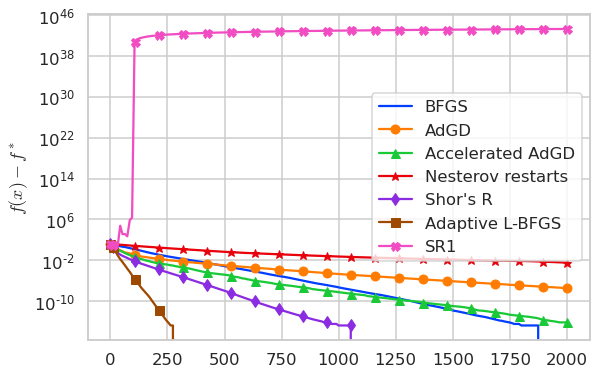

In [6]:
optimizers = get_optimizers(loss=loss)

run_and_plot(optimizers)

## Let's use smaller smoothing constant for tighter approximation

In [7]:
n, dim = 600, 100
x0 = rng.normal(scale=0.5, size=dim)
least_squares_term = False
l2 = 0

In [8]:
max_smoothing = 0.2
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2, max_smoothing=max_smoothing)
it_max = 2000

Running optimizer: BFGS
Running optimizer: AdGD
Running optimizer: Accelerated AdGD
Running optimizer: Nesterov restarts
Running optimizer: Shor's R
Running optimizer: Adaptive L-BFGS
Running optimizer: SR1


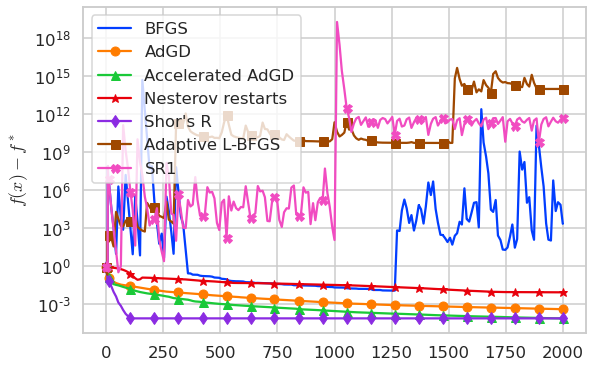

In [9]:
optimizers = get_optimizers(loss=loss)

run_and_plot(optimizers, plot_diverging=False)

### Let's remove optimizers that didnt' converge

In [10]:
def get_optimizers(loss):
    adgd = Adgd(loss=loss, label='AdGD')
    adgda = AdgdAccel(loss=loss, label='Accelerated AdGD')
    rest = RestNest(loss=loss, label='Nesterov restarts')
    shorr = Shorr(loss=loss, label='Shor\'s R')
    optimizers = [adgd, adgda, rest, shorr]
    return optimizers

### And try even smaller smoothing

Running optimizer: AdGD
Running optimizer: Accelerated AdGD
Running optimizer: Nesterov restarts
Running optimizer: Shor's R


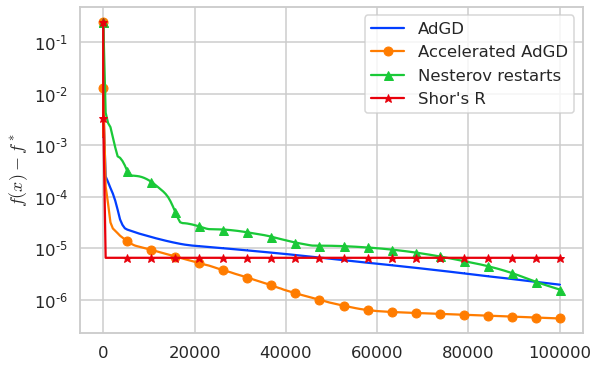

In [11]:
max_smoothing = 0.1
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2, max_smoothing=max_smoothing)
it_max = 100000
optimizers = get_optimizers(loss=loss)

run_and_plot(optimizers, plot_diverging=False)